In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')
df_submission = pd.read_csv('SampleSubmission.csv')

# Data Wrangling for the training data

In [3]:
df.head()

,VehicleID,Location,Maker,Model,Year,Colour,Amount (Million Naira),Type,Distance
0,VHL12546,Abuja,Honda,Accord Coupe EX V-6,"2,011",Silver,2.2,Nigerian Used,NaN
1,VHL18827,Ibadan,Hyundai,Sonata,"2,012",Silver,3.5,Nigerian Used,"125,000"
2,VHL19499,Lagos,Lexus,RX 350,"2,010",Red,9.2,Foreign Used,"110,852"
3,VHL17991,Abuja,Mercedes-Benz,GLE-Class,"2,017",Blue,22.8,Foreign Used,"30,000"
4,VHL12170,Ibadan,Toyota,Highlander,"2,002",Red,2.6,Nigerian Used,"125,206"


In [4]:
df.shape

(7205, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7205 entries, 0 to 7204
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   VehicleID               7205 non-null   object 
 1   Location                7205 non-null   object 
 2   Maker                   7205 non-null   object 
 3   Model                   7205 non-null   object 
 4   Year                    7184 non-null   object 
 5   Colour                  7205 non-null   object 
 6   Amount (Million Naira)  7188 non-null   float64
 7   Type                    7008 non-null   object 
 8   Distance                4845 non-null   object 
dtypes: float64(1), object(8)
memory usage: 506.7+ KB


In [6]:
df.isnull().sum()

VehicleID                    0
Location                     0
Maker                        0
Model                        0
Year                        21
Colour                       0
Amount (Million Naira)      17
Type                       197
Distance                  2360
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
#The Distance feature are strings wih commas.
#Therefore,we remove the commas and convert to float type

df['Distance'] = df['Distance'].str.replace(',','').astype(float)

In [9]:
#There are many null values in the Distance column.
#We group our dataframe by the Year column and take the mean distances and fill NaN values

df['Distance'] = df['Distance'].fillna(df.groupby('Year')['Distance'].transform('mean'))

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

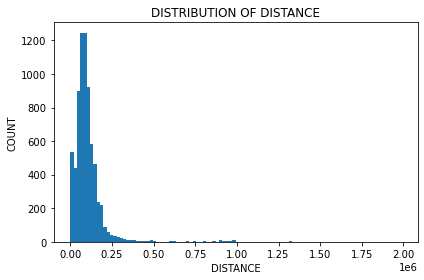

In [11]:
plt.hist(df['Distance'],bins=100);
plt.ylabel('COUNT')
plt.xlabel('DISTANCE')
plt.title('DISTRIBUTION OF DISTANCE')
plt.tight_layout()

<AxesSubplot:xlabel='Distance'>

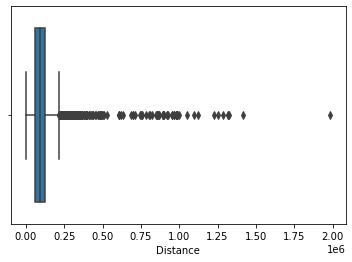

In [12]:
#We observe that our Distance data is distributed between the 0 and 100,000 excluding outliers.
#So we check for outliers with boxplots.


sns.boxplot(x='Distance',data=df)

In [13]:
#We remove the outliers by taking the 98th percentile of our dataframe and dropping the rest.

low, high = df['Distance'].quantile([0.0,0.99])
df = df[df['Distance'].between(low, high)]

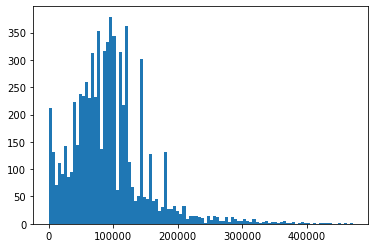

In [14]:
plt.hist(df['Distance'],bins=100);

<AxesSubplot:xlabel='Distance'>

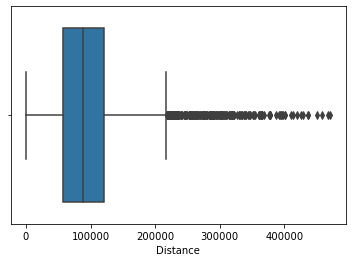

In [15]:
sns.boxplot(x='Distance',data=df)

In [16]:
#We write a function to fill NaN values in the Type column according to their distances in each row 


def cartype(cols):
    Type = cols[0]
    Distance = cols[1]
    
    if pd.isnull(Type):
        if Distance < 5000:
            return 'Brand New'
        elif Distance < 1_000_000:
            return 'Nigerian Used'
        else:
            return 'Foreign Used'
    else:
        return Type

In [17]:
df['Type'] = df[['Type','Distance']].apply(cartype,axis=1)

In [18]:
df.shape

(7126, 9)

In [19]:
df['Maker'].nunique()

55

In [20]:
makers = [maker for maker in df.Maker.value_counts().sort_values(ascending=False).index]


for maker in makers:
    df[maker] = np.where(df['Maker'] == maker,1,0)

In [21]:
df['Model'].nunique()

1213

In [22]:
models = [model for model in df.Model.value_counts().sort_values(ascending=False).index]


for model in models:
    df[model] = np.where(df['Model'] == model,1,0)

In [23]:
df['Colour'].nunique()

21

In [24]:
colours = [colour for colour in df.Colour.value_counts().sort_values(ascending=False).index]


for colour in colours:
    df[colour] = np.where(df['Colour'] == colour,1,0)

In [25]:
df['Location'].nunique()

3

In [26]:
#We substitute the categorical columns with numerical columns by getting dummy variables off of the categorical features
locations = [location for location in df.Location.value_counts().sort_values(ascending=False).index]


for location in locations:
    df[location] = np.where(df['Location'] == location,1,0)

In [27]:
#We drop the categorical columns

df.drop(columns=['Location','Maker','Colour','Model'],inplace=True)

In [28]:
df.isnull().sum()

VehicleID                  0
Year                      16
Amount (Million Naira)    17
Type                       0
Distance                   0
                          ..
Mica                       0
Pearl                      0
Lagos                      0
Abuja                      0
Ibadan                     0
Length: 1296, dtype: int64

In [29]:
#We drop the null rows because inputting NaN for the target is not ideal.
#The NaN values in this dataframe constitute a negligible percentage of the training data.


df.dropna(inplace=True)
df.reset_index(inplace=True,drop=True)

In [30]:
from sklearn.preprocessing import OrdinalEncoder

In [31]:
ordered_type = ['Nigerian Used', 'Foreign Used', 'Brand New']

In [32]:
oe = OrdinalEncoder(categories=[ordered_type])

In [33]:
df_transform = oe.fit_transform(df[['Type']])

In [34]:
oe_data = pd.DataFrame(df_transform,index=df.index, columns=['Type_oe'])

In [35]:
df = pd.concat([df,oe_data], axis=1)

In [36]:
df.drop(columns=['Type'],inplace=True)

In [37]:
#We juggle the year column and typecast the categories to integers.

df['Year'] = df['Year'].str.replace(',','').astype(int)

In [38]:
df.info()

#We now have a clean dataset but our model needs numerical columns so we use one hot encoding to achieve this.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7093 entries, 0 to 7092
Columns: 1296 entries, VehicleID to Type_oe
dtypes: float64(3), int32(1292), object(1)
memory usage: 35.2+ MB


In [39]:
#Checking the correlation of the features to look out for multicollinearity


df[['Amount (Million Naira)','Type_oe','Year','Distance']].corr()

,Amount (Million Naira),Type_oe,Year,Distance
Amount (Million Naira),1.000000,0.339992,0.454726,-0.328817
Type_oe,0.339992,1.000000,0.390619,-0.413267
Year,0.454726,0.390619,1.000000,-0.638064
Distance,-0.328817,-0.413267,-0.638064,1.000000


<AxesSubplot:>

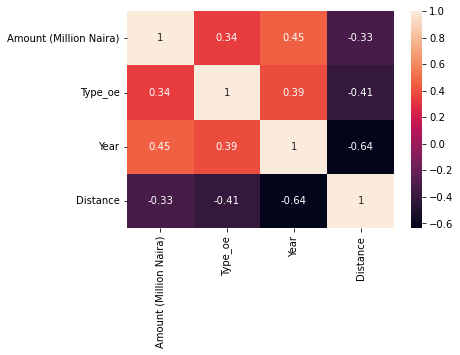

In [40]:
#Visualising the correlation between features


sns.heatmap(df[['Amount (Million Naira)','Type_oe','Year','Distance']].corr(),annot=True)

# Data Wrangling for the test data

In [41]:
df_test.head()

,VehicleID,Location,Maker,Model,Year,Colour,Type,Distance
0,VHL18518,Abuja,BMW,323i,"2,008",White,Foreign Used,30524.0
1,VHL17149,Lagos,Toyota,Camry,"2,013",White,Foreign Used,NaN
2,VHL10927,Lagos,Toyota,Highlander Limited V6,"2,005",Gold,Foreign Used,NaN
3,VHL12909,Lagos,Toyota,Camry,"2,011",Gray,Foreign Used,166839.0
4,VHL12348,Lagos,Lexus,ES 350 FWD,"2,013",Red,Foreign Used,88862.0


In [42]:
df_test.shape

(2061, 8)

In [43]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2061 entries, 0 to 2060
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   VehicleID  2061 non-null   object 
 1   Location   2061 non-null   object 
 2   Maker      2061 non-null   object 
 3   Model      2061 non-null   object 
 4   Year       2059 non-null   object 
 5   Colour     2061 non-null   object 
 6   Type       2007 non-null   object 
 7   Distance   1385 non-null   float64
dtypes: float64(1), object(7)
memory usage: 128.9+ KB


In [44]:
df_test.isnull().sum()

VehicleID      0
Location       0
Maker          0
Model          0
Year           2
Colour         0
Type          54
Distance     676
dtype: int64

In [45]:
df_test.duplicated().sum()

0

In [46]:
#There are many null values in the Distance column.
#We group our dataframe by the Year column and take the mean and/or median distances and fill NaN values

df_test['Distance'] = df_test['Distance'].fillna(df_test.groupby('Year')['Distance'].transform('mean'))
df_test['Distance'].fillna(df_test['Distance'].median(),inplace=True)

In [47]:
#Fill NaN values in the type column

df_test['Type'] = df_test[['Type','Distance']].apply(cartype,axis=1)

In [48]:
#The NaN values in this dataframe constitute a negligible percentage of the testing data.
#We fill them with the mode data in each column

df_test['Year'].fillna(df_test['Year'].mode()[0],inplace=True)

In [49]:
df_test.isnull().sum()

VehicleID    0
Location     0
Maker        0
Model        0
Year         0
Colour       0
Type         0
Distance     0
dtype: int64

In [50]:
#We substitute the categorical columns with numerical columns by getting dummy variables off of the categorical features
#locations_test = [location for location in df_test.Location.value_counts().sort_values(ascending=False).index]


for location in locations:
    df_test[location] = np.where(df_test['Location'] == location,1,0)

In [51]:
#makers_test = [maker for maker in df_test.Maker.value_counts().sort_values(ascending=False).index]


for maker in makers:
    df_test[maker] = np.where(df_test['Maker'] == maker,1,0)

In [52]:
#models_test = [model for model in df_test.Model.value_counts().sort_values(ascending=False).index]


for model in models:
    df_test[model] = np.where(df_test['Model'] == model,1,0)

In [53]:
#colours_test = [colour for colour in df_test.Colour.value_counts().sort_values(ascending=False).index]


for colour in colours:
    df_test[colour] = np.where(df_test['Colour'] == colour,1,0)

In [54]:
#We drop the categorical columns for the test data

df_test.drop(columns=['Location','Maker','Colour','Model'],inplace=True)

In [55]:
df_transform_test = oe.fit_transform(df_test[['Type']])

In [56]:
oe_data_test = pd.DataFrame(df_transform_test,index=df_test.index, columns=['Type_oe'])

In [57]:
df_test = pd.concat([df_test,oe_data_test], axis=1)

In [58]:
df_test.drop(columns=['Type','VehicleID'],inplace=True)

In [59]:
#We juggle the year column and typecast the categories to integers.

df_test['Year'] = df_test['Year'].str.replace(',','').astype(int)

In [60]:
#Import the necessary libraries


from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [61]:
X = df.drop(['VehicleID', 'Amount (Million Naira)'], axis=1)
y = df['Amount (Million Naira)']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)

In [63]:
catboost_model = CatBoostRegressor()

In [64]:
catboost_model.fit(X_train,y_train)

Learning rate set to 0.053161
0:	learn: 25.8836416	total: 142ms	remaining: 2m 21s
1:	learn: 25.2445994	total: 152ms	remaining: 1m 15s
2:	learn: 24.5857727	total: 162ms	remaining: 53.7s
3:	learn: 24.0241057	total: 171ms	remaining: 42.7s
4:	learn: 23.4200034	total: 184ms	remaining: 36.7s
5:	learn: 22.8856625	total: 198ms	remaining: 32.7s
6:	learn: 22.4171089	total: 208ms	remaining: 29.5s
7:	learn: 21.9158224	total: 219ms	remaining: 27.1s
8:	learn: 21.4342334	total: 228ms	remaining: 25.1s
9:	learn: 20.9883550	total: 238ms	remaining: 23.6s
10:	learn: 20.5525541	total: 248ms	remaining: 22.3s
11:	learn: 20.1413840	total: 257ms	remaining: 21.2s
12:	learn: 19.7351182	total: 267ms	remaining: 20.3s
13:	learn: 19.3523214	total: 276ms	remaining: 19.5s
14:	learn: 19.0388160	total: 286ms	remaining: 18.8s
15:	learn: 18.6943408	total: 295ms	remaining: 18.2s
16:	learn: 18.4159821	total: 305ms	remaining: 17.6s
17:	learn: 18.1309054	total: 314ms	remaining: 17.1s
18:	learn: 17.8487231	total: 324ms	remaini

176:	learn: 9.9181009	total: 1.96s	remaining: 9.12s
177:	learn: 9.9098409	total: 1.97s	remaining: 9.11s
178:	learn: 9.8958963	total: 1.99s	remaining: 9.11s
179:	learn: 9.8875044	total: 2s	remaining: 9.11s
180:	learn: 9.8791380	total: 2.01s	remaining: 9.09s
181:	learn: 9.8658157	total: 2.02s	remaining: 9.07s
182:	learn: 9.8372167	total: 2.03s	remaining: 9.07s
183:	learn: 9.8251158	total: 2.04s	remaining: 9.05s
184:	learn: 9.8152700	total: 2.05s	remaining: 9.03s
185:	learn: 9.7938955	total: 2.06s	remaining: 9.01s
186:	learn: 9.7712963	total: 2.07s	remaining: 9s
187:	learn: 9.7633926	total: 2.08s	remaining: 8.98s
188:	learn: 9.7432333	total: 2.09s	remaining: 8.96s
189:	learn: 9.7220023	total: 2.1s	remaining: 8.94s
190:	learn: 9.7026892	total: 2.11s	remaining: 8.92s
191:	learn: 9.6840180	total: 2.12s	remaining: 8.9s
192:	learn: 9.6765294	total: 2.13s	remaining: 8.89s
193:	learn: 9.6687093	total: 2.13s	remaining: 8.87s
194:	learn: 9.6606344	total: 2.15s	remaining: 8.86s
195:	learn: 9.653082

345:	learn: 8.0055787	total: 3.69s	remaining: 6.99s
346:	learn: 8.0003945	total: 3.71s	remaining: 6.98s
347:	learn: 7.9964955	total: 3.72s	remaining: 6.97s
348:	learn: 7.9872142	total: 3.73s	remaining: 6.96s
349:	learn: 7.9833664	total: 3.75s	remaining: 6.96s
350:	learn: 7.9699074	total: 3.76s	remaining: 6.95s
351:	learn: 7.9620450	total: 3.77s	remaining: 6.94s
352:	learn: 7.9550029	total: 3.78s	remaining: 6.93s
353:	learn: 7.9461726	total: 3.79s	remaining: 6.92s
354:	learn: 7.9368666	total: 3.81s	remaining: 6.92s
355:	learn: 7.9330181	total: 3.82s	remaining: 6.91s
356:	learn: 7.9292229	total: 3.83s	remaining: 6.89s
357:	learn: 7.9206743	total: 3.84s	remaining: 6.88s
358:	learn: 7.9040595	total: 3.85s	remaining: 6.87s
359:	learn: 7.9003073	total: 3.86s	remaining: 6.86s
360:	learn: 7.8859701	total: 3.87s	remaining: 6.84s
361:	learn: 7.8813764	total: 3.88s	remaining: 6.83s
362:	learn: 7.8704041	total: 3.9s	remaining: 6.84s
363:	learn: 7.8570944	total: 3.91s	remaining: 6.83s
364:	learn: 7

514:	learn: 6.8949918	total: 5.44s	remaining: 5.12s
515:	learn: 6.8909756	total: 5.45s	remaining: 5.11s
516:	learn: 6.8840365	total: 5.46s	remaining: 5.1s
517:	learn: 6.8815646	total: 5.47s	remaining: 5.09s
518:	learn: 6.8791193	total: 5.48s	remaining: 5.08s
519:	learn: 6.8697777	total: 5.49s	remaining: 5.07s
520:	learn: 6.8656027	total: 5.5s	remaining: 5.05s
521:	learn: 6.8631723	total: 5.51s	remaining: 5.04s
522:	learn: 6.8607644	total: 5.52s	remaining: 5.04s
523:	learn: 6.8524875	total: 5.53s	remaining: 5.03s
524:	learn: 6.8466661	total: 5.54s	remaining: 5.01s
525:	learn: 6.8361770	total: 5.55s	remaining: 5s
526:	learn: 6.8337741	total: 5.56s	remaining: 4.99s
527:	learn: 6.8300572	total: 5.58s	remaining: 4.98s
528:	learn: 6.8276789	total: 5.59s	remaining: 4.97s
529:	learn: 6.8212291	total: 5.6s	remaining: 4.96s
530:	learn: 6.8111778	total: 5.61s	remaining: 4.95s
531:	learn: 6.8020977	total: 5.62s	remaining: 4.94s
532:	learn: 6.7937015	total: 5.63s	remaining: 4.93s
533:	learn: 6.7880

688:	learn: 6.1278471	total: 7.19s	remaining: 3.25s
689:	learn: 6.1207986	total: 7.2s	remaining: 3.23s
690:	learn: 6.1181693	total: 7.21s	remaining: 3.23s
691:	learn: 6.1164826	total: 7.22s	remaining: 3.21s
692:	learn: 6.1105619	total: 7.23s	remaining: 3.2s
693:	learn: 6.1050856	total: 7.24s	remaining: 3.19s
694:	learn: 6.0995706	total: 7.25s	remaining: 3.18s
695:	learn: 6.0978993	total: 7.26s	remaining: 3.17s
696:	learn: 6.0942425	total: 7.27s	remaining: 3.16s
697:	learn: 6.0869914	total: 7.28s	remaining: 3.15s
698:	learn: 6.0853260	total: 7.29s	remaining: 3.14s
699:	learn: 6.0833643	total: 7.3s	remaining: 3.13s
700:	learn: 6.0817109	total: 7.31s	remaining: 3.12s
701:	learn: 6.0777453	total: 7.32s	remaining: 3.11s
702:	learn: 6.0751969	total: 7.33s	remaining: 3.1s
703:	learn: 6.0735574	total: 7.34s	remaining: 3.08s
704:	learn: 6.0717960	total: 7.35s	remaining: 3.07s
705:	learn: 6.0674197	total: 7.36s	remaining: 3.06s
706:	learn: 6.0656792	total: 7.37s	remaining: 3.05s
707:	learn: 6.06

860:	learn: 5.5506168	total: 8.95s	remaining: 1.45s
861:	learn: 5.5486300	total: 8.96s	remaining: 1.44s
862:	learn: 5.5450265	total: 8.97s	remaining: 1.42s
863:	learn: 5.5437939	total: 8.98s	remaining: 1.41s
864:	learn: 5.5417150	total: 9s	remaining: 1.41s
865:	learn: 5.5376742	total: 9.01s	remaining: 1.39s
866:	learn: 5.5364467	total: 9.02s	remaining: 1.38s
867:	learn: 5.5346496	total: 9.03s	remaining: 1.37s
868:	learn: 5.5334246	total: 9.04s	remaining: 1.36s
869:	learn: 5.5274900	total: 9.05s	remaining: 1.35s
870:	learn: 5.5224660	total: 9.06s	remaining: 1.34s
871:	learn: 5.5212485	total: 9.07s	remaining: 1.33s
872:	learn: 5.5188721	total: 9.08s	remaining: 1.32s
873:	learn: 5.5169702	total: 9.09s	remaining: 1.31s
874:	learn: 5.5157604	total: 9.1s	remaining: 1.3s
875:	learn: 5.5145557	total: 9.11s	remaining: 1.29s
876:	learn: 5.5133564	total: 9.12s	remaining: 1.28s
877:	learn: 5.5096558	total: 9.13s	remaining: 1.27s
878:	learn: 5.5084617	total: 9.14s	remaining: 1.26s
879:	learn: 5.505

In [65]:
np.sqrt(mean_squared_error(y_test, catboost_model.predict(X_test)))

9.663582913990739

In [66]:
catboost_predictions = catboost_model.predict(df_test)

In [67]:
first_submission = df_submission.copy()

In [68]:
first_submission.head()

,VehicleID,Amount (Million Naira)
0,VHL18518,1.0
1,VHL17149,1.0
2,VHL10927,1.0
3,VHL12909,1.0
4,VHL12348,1.0


In [69]:
first_submission["Amount (Million Naira)"] = catboost_predictions

In [70]:
first_submission.head()

,VehicleID,Amount (Million Naira)
0,VHL18518,7.251636
1,VHL17149,7.366963
2,VHL10927,4.115253
3,VHL12909,5.153555
4,VHL12348,9.068292


In [71]:
first_submission.to_csv("catboost_predictions.csv", index = False)